In [49]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [16]:
def simulate_traps(ne, nt, p):
    n_collected = 0
    for i in range(ne):
        if nt == 0:
            n_collected += ne - i
            break
        odds = (1 - p) ** nt
        if np.random.rand() < odds:
            n_collected += 1
        else:
            nt -= 1
    return n_collected

In [ ]:
n_trials = 2000
nt = 365
gain = 4.2
read_noise = 0.8 * gain
p_testvals = np.array([0.001, 0.0015, 0.002, 0.0025, 0.003])
# ne_testvals = np.rint(np.linspace(1, 2000, 100)).astype(int)
ne_testvals = np.logspace(-2, 4.2, 300)
print(ne_testvals)
n_collected = np.zeros((len(p_testvals), len(ne_testvals), n_trials))
for k, p in enumerate(p_testvals):
    for i, ne in enumerate(ne_testvals):
        print(p, i)
        # Sample Poisson distribution to get ne for each trial
        ne_array = np.random.poisson(ne, n_trials)
        # ne_array = np.ones(n_trials, 'int') * ne
        for j, ne_val in enumerate(ne_array):
            # Add some read noise
            n_collected[k, i, j] = gain * simulate_traps(ne_val, nt, p) + np.random.normal(0, read_noise)

[1.00000000e-02 1.04890411e-02 1.10019983e-02 1.15400412e-02
 1.21043966e-02 1.26963513e-02 1.33172550e-02 1.39685235e-02
 1.46516416e-02 1.53681671e-02 1.61197336e-02 1.69080548e-02
 1.77349281e-02 1.86022389e-02 1.95119648e-02 2.04661800e-02
 2.14670603e-02 2.25168877e-02 2.36180560e-02 2.47730759e-02
 2.59845810e-02 2.72553338e-02 2.85882315e-02 2.99863135e-02
 3.14527674e-02 3.29909369e-02 3.46043292e-02 3.62966230e-02
 3.80716770e-02 3.99335383e-02 4.18864524e-02 4.39348719e-02
 4.60834676e-02 4.83371384e-02 5.07010230e-02 5.31805113e-02
 5.57812567e-02 5.85091893e-02 6.13705289e-02 6.43717998e-02
 6.75198452e-02 7.08218430e-02 7.42853220e-02 7.79181793e-02
 8.17286983e-02 8.57255673e-02 8.99178996e-02 9.43152542e-02
 9.89276575e-02 1.03765626e-01 1.08840192e-01 1.14162924e-01
 1.19745960e-01 1.25602029e-01 1.31744484e-01 1.38187331e-01
 1.44945259e-01 1.52033677e-01 1.59468748e-01 1.67267425e-01
 1.75447489e-01 1.84027592e-01 1.93027297e-01 2.02467125e-01
 2.12368599e-01 2.227542

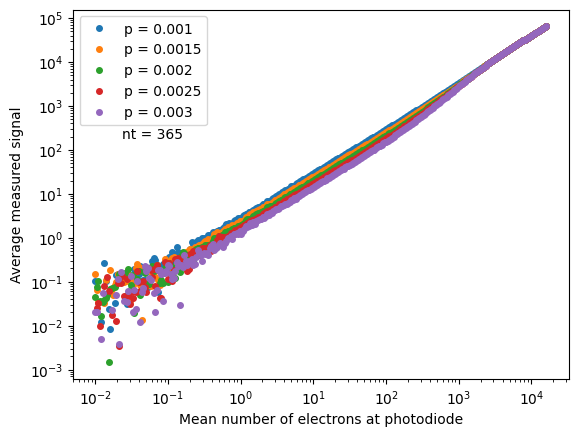

In [5]:
%matplotlib inline
for k, p in enumerate(p_testvals):
    n_collected_p = n_collected[k]
    mean_vals = np.mean(n_collected_p, axis=1)
    std_vals = np.std(n_collected_p, axis=1)
    plt.plot(ne_testvals, mean_vals, 'o', markersize=4, label=f'p = {p}')
    # Fit values above 500 to a line


plt.legend()

plt.xlabel('Mean number of electrons at photodiode')
plt.ylabel('Average measured signal')
# Add text box with p and nt
plt.text(0.1, 0.65, f'nt = {nt}', transform=plt.gca().transAxes)
# Add text for measured nt
# plt.text(0.1, 0.6, f'Measured nt = {meas_traps:.2f}', transform=plt.gca().transAxes)
plt.xscale('log')
plt.yscale('log')
plt.show()

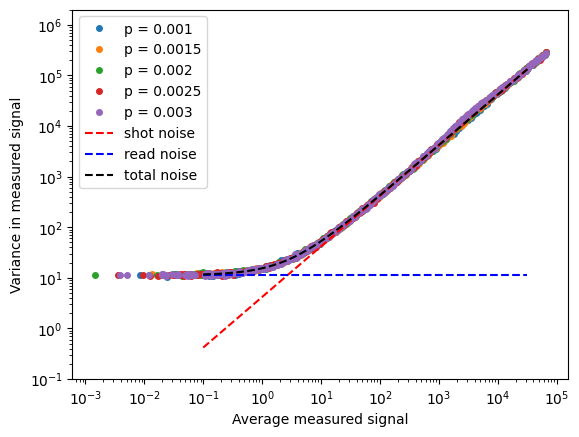

In [30]:
for k, p in enumerate(p_testvals):
    n_collected_p = n_collected[k]
    mean_vals = np.mean(n_collected_p, axis=1)
    std_vals = np.std(n_collected_p, axis=1)
    plt.plot(mean_vals, std_vals ** 2, 'o', markersize=4, label=f'p = {p}')
# plt.plot(mean_vals, std_vals ** 2, 'o')
# Plot expected value from Poisson distribution
plot_mean_val_points = np.logspace(-1, 4.5, 300)
plt.plot(plot_mean_val_points, gain * plot_mean_val_points, 'r--', label='shot noise')
plt.plot(plot_mean_val_points, np.ones_like(plot_mean_val_points) * read_noise ** 2, 'b--', label='read noise')
plt.plot(plot_mean_val_points, gain * plot_mean_val_points + read_noise ** 2, 'k--', label='total noise')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1, 2e6)
plt.xlabel('Average measured signal')
plt.ylabel('Variance in measured signal')
plt.show()

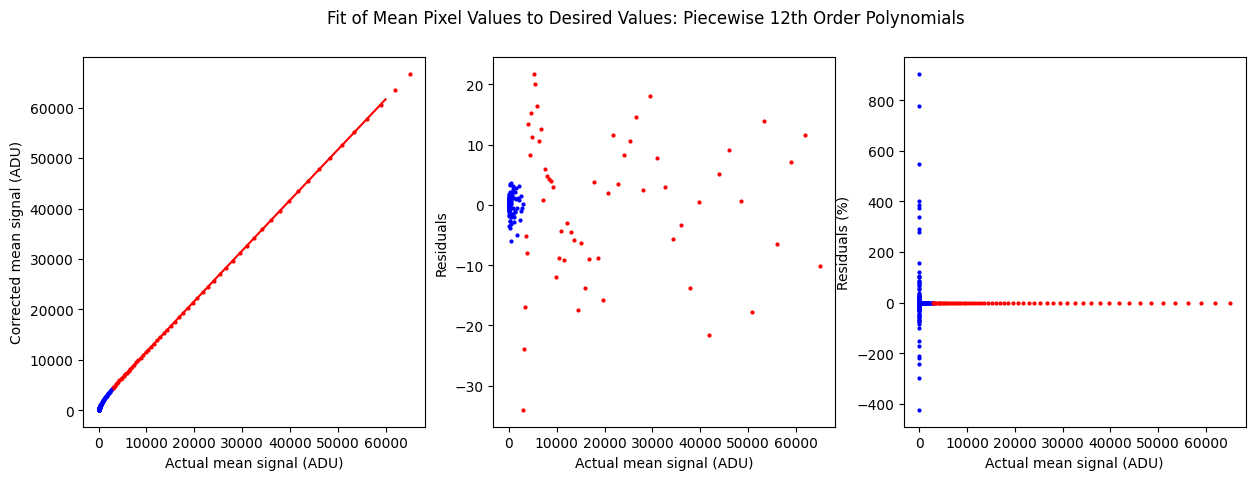

In [17]:
corrected_signal_vals = gain * ne_testvals + 100
bias_level = 100
transition_value = 3000
order_low = 12
order_high = 6
high_cutoff_value = 60000
coeff_array = np.zeros((len(p_testvals), 18))
for i, p in enumerate(p_testvals):
    mean_vals = np.mean(n_collected[i], axis=1)
    transition_idx = np.argmax(mean_vals > transition_value)
    weights = np.ones_like(mean_vals)
    # Weight lower values higher
    # weights[:10] *= 10
    popt_poly_low = np.polyfit(mean_vals[:transition_idx], corrected_signal_vals[:transition_idx],
                            order_low-1, w=weights[:transition_idx])
    popt_poly_high = np.polyfit(mean_vals[transition_idx-1:],
                                corrected_signal_vals[transition_idx-1:],
                                order_high-1, w=weights[transition_idx-1:])
    coeff_array[i, :order_low] = popt_poly_low
    coeff_array[i, order_low:] = popt_poly_high
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)

residuals_low = (corrected_signal_vals[:transition_idx] - np.polyval(popt_poly_low, mean_vals[:transition_idx]))
residuals_high = (corrected_signal_vals[transition_idx-1:] - np.polyval(popt_poly_high, mean_vals[transition_idx-1:]))
ax[0].plot(mean_vals[:transition_idx], corrected_signal_vals[:transition_idx], 'bo', markersize=2,)
ax[0].plot(mean_vals[transition_idx-1:], corrected_signal_vals[transition_idx-1:], 'ro', markersize=2)
low_signal_vals = np.arange(0, transition_value, 1)
high_signal_vals = np.arange(transition_value, high_cutoff_value, 1)
ax[0].plot(low_signal_vals, np.polyval(popt_poly_low, low_signal_vals), 'blue')
ax[0].plot(high_signal_vals, np.polyval(popt_poly_high, high_signal_vals), 'red')
ax[0].set_xlabel('Actual mean signal (ADU)')
ax[0].set_ylabel('Corrected mean signal (ADU)')
# ax[0].set_title('Polynomial Fit')
ax[1].plot(mean_vals[:transition_idx], residuals_low[:transition_idx], 'bo', markersize=2)
ax[1].plot(mean_vals[transition_idx-1:], residuals_high, 'ro', markersize=2)
ax[1].set_xlabel('Actual mean signal (ADU)')
ax[1].set_ylabel('Residuals')
# ax[1].set_title('Polynomial Fit Residuals')
residuals_percent_low = residuals_low[1:] / (corrected_signal_vals[1:transition_idx] - bias_level) * 100
residuals_percent_high = residuals_high / (corrected_signal_vals[transition_idx-1:] - bias_level) * 100
ax[2].plot(mean_vals[1:transition_idx], residuals_percent_low, 'bo', markersize=2)
ax[2].plot(mean_vals[transition_idx-1:], residuals_percent_high, 'ro', markersize=2)
ax[2].set_xlabel('Actual mean signal (ADU)')
ax[2].set_ylabel('Residuals (%)')
# ax[1].set_title('Polynomial Fit Residuals')
plt.suptitle('Fit of Mean Pixel Values to Desired Values: Piecewise 12th Order Polynomials')
plt.show()

In [19]:
def correct_images(image_stack, coeffs, transition_value, high_cutoff, bits, order_low, bias_frame=None, verbose=False):
    corrected_stack = np.zeros_like(image_stack, dtype=np.uint16)
    order_high = len(coeffs) - order_low
    if bias_frame is not None:
        image_stack = image_stack - bias_frame
    for i, frame in enumerate(image_stack):
        corrected_frame = np.zeros_like(frame, dtype=float)
        low_vals_frame = np.zeros_like(frame)
        low_vals_frame[frame <= transition_value] = frame[frame <= transition_value]
        low_vals_true_frame = frame <= transition_value
        high_vals_frame = np.zeros_like(frame)
        high_vals_frame[(frame > transition_value) & (frame < high_cutoff)] = frame[(frame > transition_value) & (frame < high_cutoff)]
        high_vals_true_frame = (frame > transition_value) & (frame < high_cutoff)
        saturated_vals_true_frame = frame >= high_cutoff
        for j in range(order_low - 1):
            corrected_frame += coeffs[j] * low_vals_frame.astype(float) ** (order_low - 1 - j)
        for j in range(order_high - 1):
            corrected_frame += coeffs[j + order_low] * high_vals_frame.astype(float) ** (order_high - 1 - j)
            # For saturated values, set the corrected value to the correction of high_cutoff
            corrected_frame += coeffs[j + order_low] * (high_cutoff * saturated_vals_true_frame).astype(float) ** (order_high - 1 - j)
        # Add the correct constant term
        corrected_frame += coeffs[order_low - 1] * low_vals_true_frame
        corrected_frame += coeffs[-1] * high_vals_true_frame
        corrected_frame += coeffs[-1] * saturated_vals_true_frame
        # Bound corrected_frame between 0 and 2**bits - 1
        corrected_frame[corrected_frame < 0] = 0
        corrected_frame[corrected_frame > 2**bits - 1] = 2**bits - 1
        # Make NaNs equal to 2 ** bits - 1
        corrected_frame[np.isnan(corrected_frame)] = 2 ** bits - 1
        corrected_stack[i] = np.rint(corrected_frame).astype(np.uint16)
        if verbose:
            print(i, np.median(corrected_stack[i]))
    return corrected_stack

In [20]:
corrected_vals = np.zeros((len(p_testvals), len(ne_testvals), n_trials))
mean_corrected_vals = np.zeros((len(p_testvals), len(ne_testvals)))
var_corrected_vals = np.zeros((len(p_testvals), len(ne_testvals)))
for k, p in enumerate(p_testvals):
    for i, ne_val in enumerate(ne_testvals):
        print(p, i)
        raw_images = n_collected[k, i]
        # Make into array of shape (1000, 1)
        raw_images = raw_images[:, np.newaxis]
        corrected_images = correct_images(raw_images, coeff_array[k], transition_value, high_cutoff_value, 16, order_low, verbose=False)
        corrected_vals[k, i] = corrected_images.flatten()
        mean_corrected_vals[k, i] = np.mean(corrected_images)
        var_corrected_vals[k, i] = np.var(corrected_images)

0.001 0
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5
0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.001 11
0.001 12
0.001 13
0.001 14
0.001 15
0.001 16
0.001 17
0.001 18
0.001 19
0.001 20
0.001 21
0.001 22
0.001 23
0.001 24
0.001 25
0.001 26
0.001 27
0.001 28
0.001 29
0.001 30
0.001 31
0.001 32
0.001 33
0.001 34
0.001 35
0.001 36
0.001 37
0.001 38
0.001 39
0.001 40
0.001 41
0.001 42
0.001 43
0.001 44
0.001 45
0.001 46
0.001 47
0.001 48
0.001 49
0.001 50
0.001 51
0.001 52
0.001 53
0.001 54
0.001 55
0.001 56
0.001 57
0.001 58
0.001 59
0.001 60
0.001 61
0.001 62
0.001 63
0.001 64
0.001 65
0.001 66
0.001 67
0.001 68
0.001 69
0.001 70
0.001 71
0.001 72
0.001 73
0.001 74
0.001 75
0.001 76
0.001 77
0.001 78
0.001 79
0.001 80
0.001 81
0.001 82
0.001 83
0.001 84
0.001 85
0.001 86
0.001 87
0.001 88
0.001 89
0.001 90
0.001 91
0.001 92
0.001 93
0.001 94
0.001 95
0.001 96
0.001 97
0.001 98
0.001 99
0.001 100
0.001 101
0.001 102
0.001 103
0.001 104
0.001 105
0.001 106
0.001 107
0.001 108
0.001 109
0.001 110


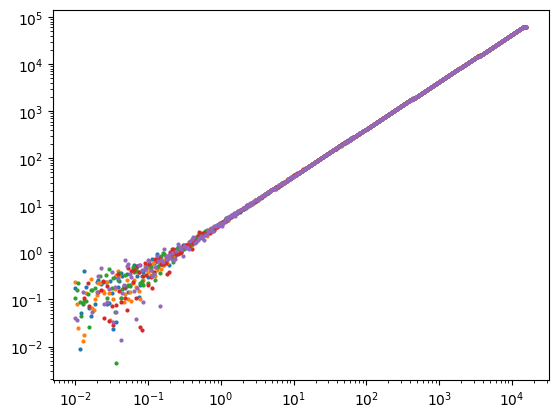

In [21]:
for i, p in enumerate(p_testvals):
    plt.plot(ne_testvals, mean_corrected_vals[i] - 100, 'o', markersize=2, label=f'p = {p}')
plt.xscale('log')
plt.yscale('log')
plt.show()

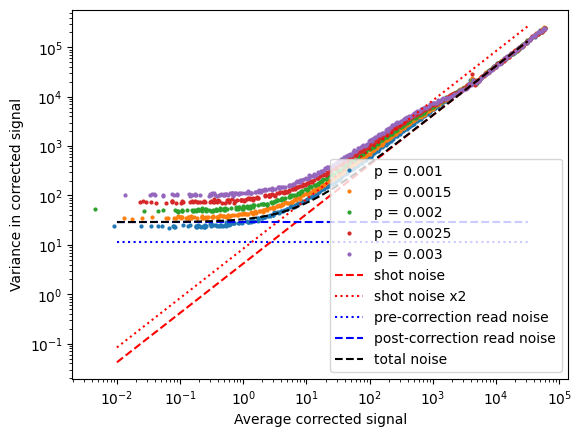

In [23]:
for i, p in enumerate(p_testvals):
    plt.plot(mean_corrected_vals[i] - 100, var_corrected_vals[i], 'o', markersize=2, label=f'p = {p}')
# plt.plot(mean_corrected_vals[2] - 100, var_corrected_vals[2], 'o', color='C1', markersize=4, label='Corrected, p=0.002')
plt.xscale('log')
plt.yscale('log')
plot_mean_val_points = np.logspace(-2, 4.5, 300)
read_noise_corrected = 0.8 * gain * 1.6
plt.plot(plot_mean_val_points, gain * plot_mean_val_points, 'r--', label='shot noise')
plt.plot(plot_mean_val_points, 2 * gain * plot_mean_val_points, 'r', linestyle='dotted', label='shot noise x2')
plt.plot(plot_mean_val_points, np.ones_like(plot_mean_val_points) * read_noise ** 2, 'b', linestyle='dotted', label='pre-correction read noise')
plt.plot(plot_mean_val_points, np.ones_like(plot_mean_val_points) * read_noise_corrected ** 2, 'b--', label='post-correction read noise')
plt.plot(plot_mean_val_points, gain * plot_mean_val_points + read_noise_corrected ** 2, 'k--', label='total noise')
plt.legend()
plt.xlabel('Average corrected signal')
plt.ylabel('Variance in corrected signal')
plt.show()

In [24]:
# Save n_collected into fits file.
from astropy.io import fits
hdu = fits.PrimaryHDU(n_collected)
hdu.header['GAIN'] = gain
hdu.header['READNOISE'] = read_noise
hdu.header['NT'] = nt
hdu.writeto('n_collected.fits', overwrite=True)

In [25]:
hdu = fits.PrimaryHDU(corrected_vals)
hdu.header['GAIN'] = gain
hdu.header['READNOISE'] = read_noise
hdu.header['NT'] = nt
hdu.writeto('model_corrected_vals.fits', overwrite=True)

Show what star images look like with and without traps

In [133]:
n_trials = 2000
nt = 350
p = 0.0035
# ne_testvals = np.rint(np.linspace(1, 2000, 100)).astype(int)
ne_testvals = np.logspace(0, 4, 100)
ne_testvals = np.unique(np.round(ne_testvals).astype(int))
n_collected = np.zeros(len(ne_testvals))
for i, ne in enumerate(ne_testvals):
    avg_n_collected = 0
    for j in range(n_trials):
        avg_n_collected += simulate_traps(ne, nt, p)
    avg_n_collected /= n_trials
    n_collected[i] = avg_n_collected
    print(f'ne = {ne}, n_collected = {avg_n_collected}')

ne = 1, n_collected = 0.288
ne = 2, n_collected = 0.592
ne = 3, n_collected = 0.864
ne = 4, n_collected = 1.1855
ne = 5, n_collected = 1.4785
ne = 6, n_collected = 1.786
ne = 7, n_collected = 2.0605
ne = 8, n_collected = 2.382
ne = 9, n_collected = 2.638
ne = 10, n_collected = 2.9535
ne = 11, n_collected = 3.3015
ne = 12, n_collected = 3.5225
ne = 14, n_collected = 4.208
ne = 15, n_collected = 4.464
ne = 16, n_collected = 4.727
ne = 18, n_collected = 5.355
ne = 20, n_collected = 6.0815
ne = 22, n_collected = 6.698
ne = 24, n_collected = 7.2935
ne = 26, n_collected = 7.832
ne = 28, n_collected = 8.542
ne = 31, n_collected = 9.447
ne = 34, n_collected = 10.411
ne = 38, n_collected = 11.579
ne = 41, n_collected = 12.7235
ne = 45, n_collected = 13.901
ne = 50, n_collected = 15.5225
ne = 55, n_collected = 17.251
ne = 60, n_collected = 18.86
ne = 66, n_collected = 20.8185
ne = 72, n_collected = 23.047
ne = 79, n_collected = 25.439
ne = 87, n_collected = 28.3685
ne = 95, n_collected = 31.3835

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_39258/2939155100.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


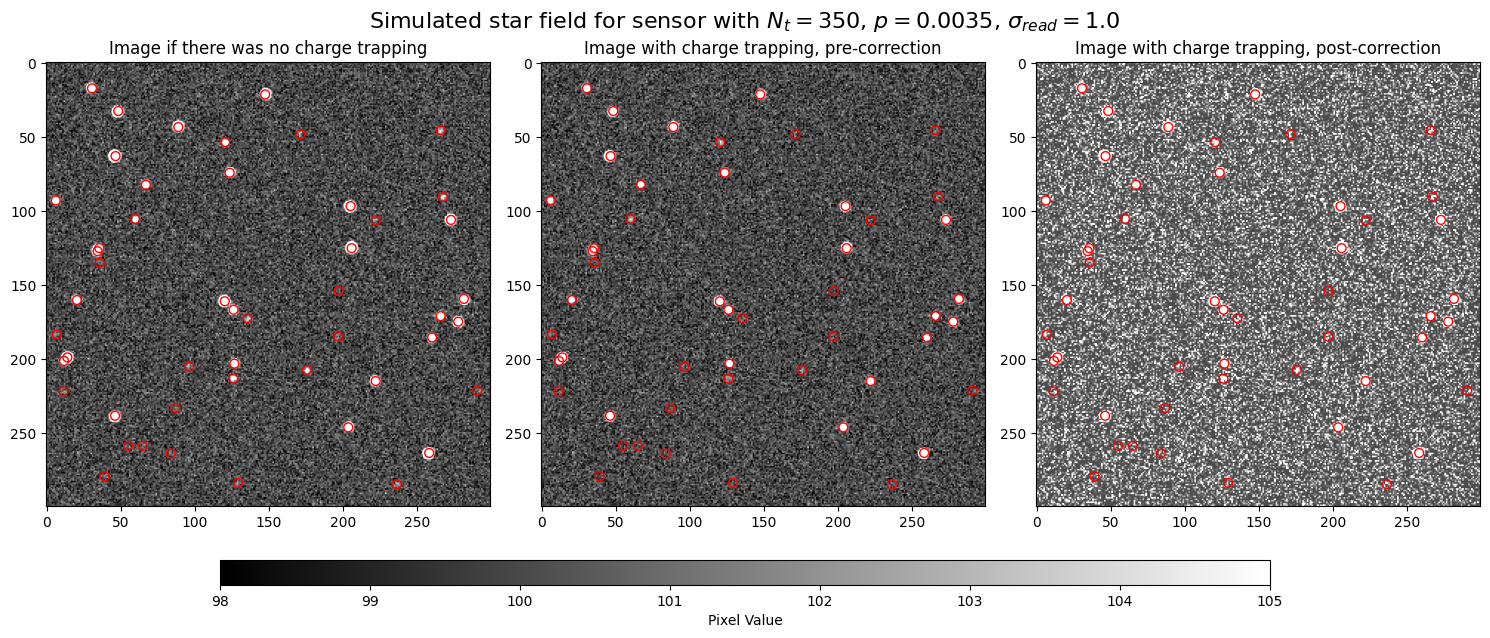

In [134]:
from scipy.stats import loguniform
from scipy.interpolate import interp1d
trap_interpolator = interp1d(ne_testvals, n_collected, bounds_error=False, fill_value='extrapolate')
correction_interpolator = interp1d(n_collected, ne_testvals, bounds_error=False, fill_value='extrapolate')

# Image parameters
image_size = (300, 300)
n_stars = 50
fwhm = 3.0  # in pixels
sigma = fwhm / 2.355  # convert FWHM to sigma
bias_level = 100
read_noise_std = 1.0

# Initialize image with bias
image = np.random.normal(loc=0, scale=read_noise_std, size=(image_size[0], image_size[1])) + bias_level
image_with_traps = copy.deepcopy(image)

# Create the stellar PSF
size = int(10 * sigma)
if size % 2 == 0:
    size += 1
half = size // 2
y_grid, x_grid = np.meshgrid(np.arange(-half, half + 1), np.arange(-half, half + 1), indexing='ij')

# Gaussian PSF
psf = np.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
psf /= np.sum(psf)  # normalize

# Generate random stars
np.random.seed(1)  # for reproducibility
star_pos_arr = np.random.uniform(half, image_size[0] - half, (n_stars, 2))
star_flux_arr = loguniform.rvs(10, 10000, size=n_stars)  # random fluxes between 1 and 1000 ADU
for i in range(n_stars):
    x, y = star_pos_arr[i]
    flux = star_flux_arr[i]
    star_psf = psf * flux  # scale to desired total flux
    star_psf_with_traps = trap_interpolator(star_psf)
    # Add to image
    x_int, y_int = int(round(x)), int(round(y))
    x_start, x_end = x_int - half, x_int + half + 1
    y_start, y_end = y_int - half, y_int + half + 1
    # Boundaries
    if (x_start < 0 or y_start < 0 or x_end > image_size[1] or y_end > image_size[0]):
        continue  # skip stars too close to the edge
    image[y_start:y_end, x_start:x_end] += star_psf
    image_with_traps[y_start:y_end, x_start:x_end] += star_psf_with_traps
image_corrected = copy.deepcopy(image_with_traps) - bias_level  # remove bias level from the image with traps
image_corrected[image_corrected < 0] = 0  # ensure no negative values after bias removal
image_corrected = correction_interpolator(image_corrected) + bias_level  # apply charge trapping correction
image_corrected[image_corrected == 1] = 0

# Make 3 panels for the image. First is the original image, second is the image with traps. Leave 3rd blank for now
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# I want imshows to share colorbar

im0 = ax[0].imshow(image, cmap='gray', vmin=98, vmax=105)
ax[0].set_title('Image if there was no charge trapping')
ax[1].imshow(image_with_traps, cmap='gray', vmin=98, vmax=105)
ax[1].set_title('Image with charge trapping, pre-correction')
ax[2].imshow(image_corrected, cmap='gray', vmin=98, vmax=105)
ax[2].set_title('Image with charge trapping, post-correction')
# Add one colorbar for all images
cbar_ax = fig.add_axes([0.15, -0.1, 0.7, 0.05])  # [left, bottom, width, height]
fig.colorbar(im0, cax=cbar_ax, label='Pixel Value', orientation='horizontal')
# Put red circles around all stars in the images
for i in range(n_stars):
    x, y = star_pos_arr[i]
    circle_0 = plt.Circle((x, y), fwhm, color='red', fill=False)
    ax[0].add_artist(circle_0)
    circle_1 = plt.Circle((x, y), fwhm, color='red', fill=False)
    ax[1].add_artist(circle_1)
    circle_2 = plt.Circle((x, y), fwhm, color='red', fill=False)
    ax[2].add_artist(circle_2)
plt.tight_layout()
plt.suptitle(f'Simulated star field for sensor with $N_t={nt}$, $p={p}$, $\sigma_{{read}}={read_noise_std}$', y=1.05, fontsize=16)
plt.show()

In [103]:
np.mean(image_corrected), np.mean(image)

(101.54750532351592, 100.86620783771885)